In [1]:
import os
import sys
os.environ['USE_PYGEOS'] = '0'
import numpy as np
import geopandas as gpd
from shapely import Point, MultiPoint, Polygon, LineString, LinearRing, delaunay_triangles, MultiLineString, distance, MultiPolygon, covers, contains_xy, build_area, GeometryCollection
import matplotlib.pyplot as plt
from concave_hull import concave_hull, concave_hull_indexes
import pandas as pd
import copy
from pyproj import CRS, Transformer, Proj
import scipy
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.patches import Patch
import seaborn as sns
import mapclassify as mc
import matplotlib as mpl
import math

In [2]:
class Vertice():
    def __init__(self, pnt=(0, 0, 0), i=None, he_list=[], status=None, coast_dist=0) -> None:
        self.pnt = Point(pnt)
        self.i = i
        self.he_list=he_list.copy()
        self.status=status
        self.coast_dist = coast_dist
        self.deep = 0
        self.grad = [None, None]
    def show(self):
        print(self.pnt, self.i, self.he_list, self.status)

class Hedge():
    def __init__(self, i=None, origin=None, face=None, twin=None, next=None, prev=None, edge=None) -> None:
        self.i = i
        self.origin = origin
        self.face = face
        self.twin = twin
        self.next = next
        self.prev = prev
        self.edge = edge
    def show(self):
        print(self.lin, self.i, self.origin, self.face, self.twin, self.next, self.prev)
class Edge():
    def __init__(self, lin=((0, 0), (0, 0)), hedge=None) -> None:
        self.lin = LineString(lin)
        self.hedge=hedge
        self.grad = 0

class Face():
    def __init__(self, pol=(Point(0, 0, 0), Point(0, 0, 0), Point(0, 0, 0), Point(0, 0, 0)), i=None, p0=None, p1=None, p2=None, outer=None) -> None:
        self.pol = Polygon(pol)
        self.i = i
        self.p0, self.p1, self.p2 = p0, p1, p2
        self.outer = outer
        self.normal = [0, 0, 1]
    def show(self):
        print(self.pol, self.i, self.p0, self.p1, self.p2, self.outer)


In [15]:
class Triangulation():
    def __init__(self, data, border, crs='EPSG:4326'):        
        if type(border) == str:
            border = gpd.read_file(border).copy()
        if type(data) == str:
            data = gpd.read_file(data).copy()

        if type(border.geometry[0]) == LineString:
            self.ml = MultiLineString(list(border.geometry))
            mp = MultiPolygon([build_area(GeometryCollection(list(border.geometry)))])
        else: 
            mp = MultiPolygon(list(border.geometry))
            mls = []
            for g in mp.geoms:
                mls.append(g.exterior)
                mls += list(g.interiors)
            self.ml = MultiLineString(mls)
        
        self.crs=crs
        pts_i = []
        self.zs=[]
        self.vertices = []
        self.hedges = []
        self.faces = []
        self.edges = []
        if data.geometry[0] == None:
            for index, i in data.iterrows():
                pts_i.append(Point(float(i.lon), float(i.lat), index))
                self.vertices.append(Vertice((float(i.lon), float(i.lat), float(i.H_sr)), len(self.vertices)))
                self.zs.append(float(i.H_sr))  
        else:
            for index, i in data.iterrows():
                pts_i.append(Point(i.geometry.x, i.geometry.y, index))
                self.vertices.append(Vertice((i.geometry.x, i.geometry.y, float(i.field_3)), len(self.vertices)))
                self.zs.append(float(i.field_3))  
        dT = gpd.GeoSeries(delaunay_triangles(MultiPoint(pts_i)).geoms)

        
        for tr in dT:
            i0 = int(tr.exterior.coords[0][2])
            i1 = int(tr.exterior.coords[1][2])
            i2 = int(tr.exterior.coords[2][2])
            cx = (self.vertices[i0].pnt.x + self.vertices[i1].pnt.x + self.vertices[i2].pnt.x) / 3
            cy = (self.vertices[i0].pnt.y + self.vertices[i1].pnt.y + self.vertices[i2].pnt.y) / 3
            #cross = self.ml.crosses(tr)
            if not contains_xy(mp, cx, cy): #and not cross:
                continue
            self.faces.append(Face((self.vertices[i0].pnt, self.vertices[i1].pnt, self.vertices[i2].pnt, self.vertices[i0].pnt), len(self.faces), i0, i1, i2))
            for p in (i0, i1, i2):
                self.hedges.append(Hedge(len(self.hedges), p, len(self.faces) - 1))
                self.vertices[p].he_list.append(len(self.hedges) - 1)

            e = len(self.hedges)
            self.faces[len(self.faces) - 1].outer = self.hedges[e - 3].i

            eis = [e-1, e-2, e-3]
            for i in range(3):          
                self.hedges[eis[i]].next = eis[i-1]
                self.hedges[eis[i]].prev = eis[i-2]

            for he in range(e - 3, e):
                for i in self.vertices[self.hedges[self.hedges[he].next].origin].he_list:
                    if self.hedges[self.hedges[i].next].origin == self.hedges[he].origin:
                        self.hedges[i].twin = he
                        self.hedges[he].twin = i
                        break

            self.faces[len(self.faces) - 1].outer = e - 3
        for he in self.hedges:
            if he.twin == None:
                he.twin = he.i
        self.calculate_edges()

      
    def show(self, ax):
        gpd.GeoSeries.plot(gpd.GeoSeries([i.lin for i in self.edges]), ax=ax)
        gpd.GeoSeries.plot(gpd.GeoSeries([p.pnt for p in self.vertices]), ax=ax)

    def show_coast(self, ax):
        gpd.GeoSeries.plot(gpd.GeoSeries(self.ml), ax=ax)
        gpd.GeoSeries.plot(gpd.GeoSeries([p.pnt for p in self.vertices]), ax=ax)

    def change_projection(self, new_crs):
        crs1 = CRS(self.crs)
        crs2 = CRS(new_crs)
        trans = Transformer.from_crs(crs1, crs2)  
        if crs1.is_geographic and crs2.is_projected or crs2.is_geographic and crs1.is_projected:
            for v in self.vertices:
                x, y= trans.transform(v.pnt.y, v.pnt.x, errcheck = True)
                v.pnt = Point(x, y, v.pnt.z)
            self.ml = MultiLineString([LineString([trans.transform(i.xy[1][j], i.xy[0][j], errcheck = True) for j in range(len(i.xy[0]))]) for i in self.ml.geoms])
        else: 
            for v in self.vertices:
                x, y = trans.transform(v.pnt.x, v.pnt.y, errcheck = True)
                v.pnt = Point(x, y, v.pnt.z)
            self.ml = MultiLineString([LineString([trans.transform(i.xy[0][j], i.xy[1][j], errcheck = True) for j in range(len(i.xy[0]))]) for i in self.ml.geoms])
        for f in self.faces:
            f.pol = Polygon((self.vertices[f.p0].pnt,  self.vertices[f.p1].pnt, self.vertices[f.p2].pnt, self.vertices[f.p0].pnt))
        for e in self.edges:
            e.lin = LineString((self.vertices[self.hedges[e.hedge].origin].pnt, self.vertices[self.hedges[self.hedges[e.hedge].next].origin].pnt))
        
        self.crs=new_crs



    def calculate_levels(self, levels=[]):

        def get_level_pnt(p0, p1, level, linePnts):
            linePnts.append((int(p0.x + (p0.z-level)/(p0.z-p1.z)*(p1.x-p0.x)), int(p0.y + (p0.z-level)/(p0.z-p1.z)*(p1.y-p0.y))))

        def get_level_line(tr, level, trs_viewed):
            linePnts = []
            #print("New_line!")
            p0 = self.vertices[self.hedges[tr.outer].origin].pnt
            p1 = self.vertices[self.hedges[self.hedges[tr.outer].next].origin].pnt
            p2 = self.vertices[self.hedges[self.hedges[tr.outer].prev].origin].pnt
            if (p0.z - level) * (p1.z - level) < 0 or (p0.z - level) * (p2.z - level) < 0 or (p2.z - level) * (p1.z - level) < 0:
                trs_viewed[tr.i] = 1
                if (p0.z - level) * (p1.z - level) >= 0:
                    get_level_pnt(p1, p2, level, linePnts)
                    get_level_pnt(p0, p2, level, linePnts)
                    he_i = self.hedges[self.hedges[tr.outer].prev].twin
                elif (p0.z - level) * (p2.z - level) >= 0:
                    get_level_pnt(p0, p1, level, linePnts)
                    get_level_pnt(p1, p2, level, linePnts)
                    he_i = self.hedges[self.hedges[tr.outer].next].twin
                elif (p1.z - level) * (p2.z - level) >= 0:
                    get_level_pnt(p0, p2, level, linePnts)
                    get_level_pnt(p0, p1, level, linePnts)
                    he_i = self.hedges[tr.outer].twin
                else:
                    print("Первый иф дал сбой!!!")
                    return "Error"
                #print(tr.i, he_i)

                afterboarder = False
                start = True
                n = 0
                while self.hedges[he_i].face != tr.i and n < len(self.faces) or start:
                    n+=1
                    start = False
                    if he_i == self.hedges[he_i].twin and not afterboarder:
                        #print('aaa')
                        if self.vertices[self.hedges[he_i].origin].pnt.z > level:
                            p_next = self.vertices[self.hedges[he_i].origin]
                        elif self.vertices[self.hedges[self.hedges[he_i].next].origin].pnt.z > level:
                            p_next = self.vertices[self.hedges[self.hedges[he_i].next].origin]
                        else:
                            print("У последнего треугольника горизонталь не на ребре!!!")
                            return "Error"
                            
                        he_i_next = he_i
                        while p_next.pnt.z > level:
                            p = p_next
                            he_i = he_i_next
                            linePnts.append((p.pnt.x, p.pnt.y))
                            #print(f'making a: {self.hedges[he_i].face}, {he_i}, {p.i}')
                            
                            for he in p.he_list:
                                if he == self.hedges[he].twin and he != he_i:
                                    he_i_next = he
                                    p_next = self.vertices[self.hedges[self.hedges[he_i_next].next].origin]
                                    break
                                elif self.hedges[he].prev == self.hedges[self.hedges[he].prev].twin and self.hedges[he].prev != he_i:
                                    he_i_next = self.hedges[he].prev
                                    p_next = self.vertices[self.hedges[he_i_next].origin]
                                    break
                                else:
                                    continue
                        he_i = he_i_next
                        get_level_pnt(p_next.pnt, p.pnt, level, linePnts)
                        #print(f'end a: {self.hedges[he_i].face}, {he_i}')
                        afterboarder = True
                    else:
                        #print(self.hedges[he_i].face, he_i)
                        trs_viewed[self.hedges[he_i].face] = 1
                        p0 = self.vertices[self.hedges[he_i].origin].pnt
                        p1 = self.vertices[self.hedges[self.hedges[he_i].next].origin].pnt
                        p2 = self.vertices[self.hedges[self.hedges[he_i].prev].origin].pnt
                        if (p0.z - level) * (p2.z - level) >= 0: 
                            get_level_pnt(p1, p2, level, linePnts)
                            he_i = self.hedges[self.hedges[he_i].next].twin
                        elif (p1.z - level) * (p2.z - level) >= 0:
                            get_level_pnt(p0, p2, level, linePnts)
                            he_i = self.hedges[self.hedges[he_i].prev].twin
                        else:
                            print("У следующего треугольника нет горизонтали!!!")
                            ax = gpd.GeoSeries([v.pnt for v in self.vertices]).plot(figsize=[200, 100])
                            gpd.GeoSeries.plot(gpd.GeoSeries(LineString(linePnts)), ax=ax)
                            gpd.GeoSeries.plot(gpd.GeoSeries([i.lin for i in self.edges]), ax=ax)
                            plt.draw()
                            return "Error"
                                                  
                        afterboarder = False

                if n == len(self.faces):
                    print("Бесконечный цикл!!!")
                    ax = gpd.GeoSeries([v.pnt for v in self.vertices]).plot(figsize=[200, 100])
                    gpd.GeoSeries.plot(gpd.GeoSeries(LineString(linePnts)), ax=ax)
                    gpd.GeoSeries.plot(gpd.GeoSeries(Point(linePnts[-1])), ax=ax, color='r')
                    plt.draw()
                    return "Error"
                
                return LineString(linePnts)
            else:
                return None
            
        self.contours = dict()
        self.areas = dict()
        self.levels = levels
        for v in self.vertices:
            if v.pnt.z in levels:
                v.pnt = Point(v.pnt.x, v.pnt.y, v.pnt.z+0.001)
        for level in levels:
            trs_viewed = [0] * len(self.faces)
            self.contours[level] = []
            for tr in self.faces:
                if trs_viewed[tr.i] == 1:
                    continue
                line = get_level_line(tr, level, trs_viewed)
                if line == "Error":
                    print("\n\n\nError\n\n\n")
                    break
                if line != None:
                    self.contours[level].append(line)
                    if not line.is_closed:
                        print(line)
              
            print(GeometryCollection(self.contours[level]))
            self.areas[level] = build_area(GeometryCollection(self.contours[level]))
            for i in self.ml.geoms:
                if covers(self.areas[level], i):
                    self.areas[level] = build_area(GeometryCollection([self.areas[level], i]))
            self.areas[level] = self.areas[level] if self.contours[level] != [] else build_area(GeometryCollection(self.ml))
            self.contours[level] = MultiLineString(self.contours[level])

    def draw_levels(self, ax, ground, sea, cmap='BuGn'):
        #gpd.GeoSeries.plot(gpd.GeoSeries([p.pnt for p in self.vertices]), ax = ax)
        gpd.GeoSeries.plot(gpd.GeoSeries([self.areas[i] for i in self.levels]), cmap=cmap, ax=ax, zorder=1)
        gpd.GeoSeries.plot(gpd.GeoSeries([self.contours[i] for i in self.contours]), color = "k", ax=ax, linewidth = 1, zorder =2)
        gpd.GeoSeries.plot(sea, ax=ax, color='#f1f1f5', edgecolor='C0', linewidth = 1, zorder = 4)
        gpd.GeoSeries.plot(ground, ax=ax, color='#afafaf', edgecolor='C0', linewidth = 1, zorder = 5)
        gpd.GeoSeries.plot(gpd.GeoSeries([self.ml]), ax=ax, color='C0', linewidth = 1, zorder = 3)

    def feel_diff(self, other, path):
        a = scipy.stats.kstest(other.zs, self.zs).statistic
        plt.figure(figsize=[10, 10])
        draw_ecdf(other.zs.copy(), plt, c='r')
        draw_ecdf(self.zs.copy(), plt, c='b')
        plt.title(f'kolmo: {a}')
        
        plt.show()
        fig, axes = plt.subplots(1, 2, figsize = (100, 100))
        self.show_levels(levels=[0.4, 0.6, 0.8], ax=axes[0])
        other.show_levels(levels=[0.4, 0.6, 0.8], ax=axes[1])
        plt.show()
        new_t = copy.deepcopy(other)
        for i in range(len(other.vertices)):
            new_t.vertices[i].pnt = Point(other.vertices[i].pnt.x, other.vertices[i].pnt.y, other.vertices[i].pnt.z - self.vertices[i].pnt.z)
        new_t.save_to_shp(path + r'\DIF_MAP.shp')
        other.save_to_shp(path + r'\T1_VIEW.shp')
        self.save_to_shp(path + r'\T2_VIEW.shp')


    def smoother(self):
        new_t = copy.deepcopy(self)
        for v in new_t.vertices:
            s = self.vertices[v.i].pnt.z
            n = 1
            for he in self.vertices[v.i].he_list:
                s += self.vertices[self.hedges[self.hedges[he].next].origin].pnt.z
                if self.hedges[self.hedges[he].prev].i == self.hedges[self.hedges[he].prev].twin:
                    s += self.vertices[self.hedges[self.hedges[he].prev].origin].pnt.z
                    n += 1    
                n += 1

            v.pnt = Point((self.vertices[v.i].pnt.x, self.vertices[v.i].pnt.y, s / n))
        new_t.zs = [i.pnt.z for i in new_t.vertices]
        return new_t
    
    def calculate_stat(self):
        sum = 0
        sq = 0
        mn = min([math.sqrt(tr.normal[0]**2 + tr.normal[1]**2) for tr in self.faces])
        for tr in self.faces:
            sum += (math.exp(math.sqrt(tr.normal[0]**2 + tr.normal[1]**2) + 15) - math.exp(mn + 15)) * tr.pol.area
            sq += tr.pol.area
        return sum / sq
    def calculate_edges(self):
        he_copy = self.hedges.copy()
        for he in he_copy:
            if he == None:
                continue
            p1 = self.vertices[he.origin].pnt
            p2 = self.vertices[self.hedges[he.next].origin].pnt
            self.edges.append(Edge((Point(p1.x, p1.y), Point(p2.x, p2.y)), he.i))
            self.hedges[he.i].edge = len(self.edges) - 1
            if he.twin != None:
                self.hedges[he.twin].edge = len(self.edges) - 1
                he_copy[he.twin] = None 
    def calculate_distance(self, coast):
        t = copy.deepcopy(self)
        for v in self.vertices:
            v.coast_dist = distance(coast, Point([v.pnt.x, v.pnt.y]))
            t.vertices[v.i].pnt = Point(v.pnt.x, v.pnt.y, v.coast_dist/1000000) #в тысячах км
        t.calculate_grad()
        for v in self.vertices:
            v.grad_dist = t.vertices[v.i].grad
        
    def calculate_grad(self):
        for tr in self.faces:
            p0 = self.vertices[tr.p0].pnt
            p1 = self.vertices[tr.p1].pnt
            p2 = self.vertices[tr.p2].pnt
            longx = (p1.y - p0.y) * (p2.z - p0.z) - (p2.y - p0.y) * (p1.z - p0.z)
            longy = (p1.z - p0.z) * (p2.x - p0.x) - (p2.z - p0.z) * (p1.x - p0.x)
            longz = (p1.x - p0.x) * (p2.y - p0.y) - (p2.x - p0.x) * (p1.y - p0.y)
            leng = math.sqrt(longx**2 + longy**2 + longz**2)
            tr.normal = [longx/leng, longy/leng, longz/leng]
        for e in self.edges:
            e.grad = (self.vertices[self.hedges[e.hedge].origin].pnt.z - self.vertices[self.hedges[self.hedges[e.hedge].next].origin].pnt.z) / e.lin.length
        for v in self.vertices:
            grad = [0, 0, 0]
            for he in v.he_list:
                for i in range(3):
                    grad[i] += self.faces[self.hedges[he].face].normal[i] * self.faces[self.hedges[he].face].pol.area / (
                        self.edges[self.hedges[he].edge].lin.length**2 * self.edges[self.hedges[self.hedges[he].prev].edge].lin.length**2)
            leng = math.sqrt(grad[0]**2 + grad[1]**2 + grad[2]**2)
            leng = leng if leng != 0 else 1
            v.grad = [grad[0]/leng, grad[1]/leng]

    def show_grad(self, ax):
        t1 = copy.deepcopy(self)
        for p in t1.vertices:
            p.pnt = Point(p.pnt.x, p.pnt.y, math.sqrt(p.grad[0]**2+p.grad[1]**2))
        gradlist = [math.sqrt(p.grad[0]**2+p.grad[1]**2) for p in t1.vertices]
        self.levels = [0, (min(gradlist)+max(gradlist)) / 2]
        t1.calculate_levels(levels=self.levels)
        print(self.levels)
        t1.draw_levels(ax)

    def push_value_by_min(self, coast):
        self.calculate_distance(coast)
        new_t = copy.deepcopy(self)
        for i in range(len(new_t.vertices)):
            z = self.vertices[i].pnt.z
            min = self.vertices[i].coast_dist
            for he in self.vertices[i].he_list:
                if self.vertices[self.hedges[self.hedges[he].next].origin].coast_dist > min:
                    continue
                min = self.vertices[self.hedges[self.hedges[he].next].origin].coast_dist
                z = self.vertices[self.hedges[self.hedges[he].next].origin].pnt.z

            new_t.vertices[i].pnt = Point((self.vertices[i].pnt.x, self.vertices[i].pnt.y, z))
        new_t.zs = [i.pnt.z for i in new_t.vertices]
        return new_t
                
    def save_to_shp(self, path):
        d = {'par': [i.pnt.z for i in self.vertices if i.status=='water'], 'geometry': [i.pnt for i in self.vertices if i.status=='water']}
        gpd.GeoDataFrame(d, crs=self.crs).to_file(path)
        
    def save_to_csv(self, path):
        xes1 = pd.Series([i.pnt.x for i in self.vertices if i.status=='water'])
        yes1 = pd.Series([i.pnt.y for i in self.vertices if i.status=='water'])
        zes1 = pd.Series([i.pnt.z for i in self.vertices if i.status=='water'])
        pd.DataFrame(data={'x':xes1, 'y':yes1, 'z':zes1}).to_csv(path)



In [16]:
def draw_levels_smart(self, ax, ground, sea):
    #gpd.GeoSeries.plot(gpd.GeoSeries([p.pnt for p in self.vertices]), ax = ax)
    gpd.GeoSeries.plot(gpd.GeoSeries([self.areas[i] for i in self.levels]), cmap='Reds', ax=ax, zorder=1)
    gpd.GeoSeries.plot(gpd.GeoSeries([self.contours[i] for i in self.contours]), color = "k", ax=ax, linewidth = 1, zorder =2)
    cs=mpl.cm.ScalarMappable(norm=mpl.colors.BoundaryNorm(self.levels + [max(self.zs)], mpl.cm.Reds.N), cmap='Reds').to_rgba(self.levels + [max(self.zs)])
        
    for i, level in enumerate(self.contours):
        for g in self.contours[level].geoms:
            ax.text(*g.coords[0], str(level),
                            size="medium", rotation=40,
                            horizontalalignment='center', verticalalignment='center', 
                            bbox = dict(boxstyle="square,pad=0.", ec="none", fc=cs[i - 1], alpha=1, zorder=5), 
                            zorder=5, in_layout = False)
    
    gpd.GeoSeries.plot(sea, ax=ax, color='#f1f1f5', edgecolor='C0', linewidth = 1, zorder = 3)
    gpd.GeoSeries.plot(ground, ax=ax, color='#afafaf', edgecolor='C0', linewidth = 1, zorder = 4)

In [17]:
scale = {'Kasp': 1, 'Barenz': 2}
def make_scaleImg_series(t, xc, yc, ground, sea, k=1, mode='izo', cmap='BuGn', name="Средняя высота волны, м"):
    fig, ax = plt.subplots(2, 2, figsize=[10, 10])
    move = [90000 * k, 200000 * k, 600000 * k, 1100000 * k]

    for i in range(4):
        ax[i//2, i%2].set_xlim(xc - move[i], xc + move[i])
        ax[i//2, i%2].set_ylim(yc - move[i], yc + move[i])
        ax[i//2, i%2].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
        ax[i//2, i%2].add_artist(ScaleBar(dx=1, location='lower right'))
        if mode == 'izo':
            t[i].draw_levels(ax[i//2, i%2], ground=ground, sea=sea, cmap=cmap)
        else:
            t[i].show(ax[i//2, i%2])
        #plt.subplots_adjust(wspace=0.01, hspace=0.01)
    fig.tight_layout()
    plt.show()

    fig, ax = plt.subplots(figsize=(3, 0.3))
    fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.BoundaryNorm(t[0].levels + [max(t[0].zs)], mpl.cm.Reds.N), cmap=cmap),
                  label=name, drawedges=True, format="{x:.1f}", orientation='horizontal', cax=ax, shrink=0.5)

In [18]:
def make_closeImg_series(t, xc, yc, ground, sea, ext=90000, cmap='BuGn', name="Средняя высота волны, м"):
    fig, ax = plt.subplots(2, 2, figsize=[10, 10])
    move = [ext] * 4
    titles = []
  
    for i in range(4):
        ax[i//2, i%2].set_xlim(xc - move[i], xc + move[i])
        ax[i//2, i%2].set_ylim(yc - move[i], yc + move[i])
        ax[i//2, i%2].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
        ax[i//2, i%2].add_artist(ScaleBar(dx=1, location='lower right'))
        t[i].draw_levels(ax[i//2, i%2], ground=ground, sea=sea, cmap=cmap)
    #plt.subplots_adjust(wspace=0.01, hspace=0.01)
    fig.tight_layout()
    plt.show()

    fig, ax = plt.subplots(figsize=(10, 0.3))
    fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.BoundaryNorm(t[0].levels + [max(t[0].zs)], mpl.cm.Reds.N), cmap=cmap),
                  label=name, drawedges=True, format="{x:.5f}", orientation='horizontal', cax=ax, shrink=0.5)

In [19]:
def draw_ecdf(data, ax, c = 'b'):
    data.sort()
    y = []
    x = np.linspace(min(data), max(data), 1000)
    j_last = 0
    for i in x:
        for j in range(j_last, len(data)):
            if data[j] >= i:
                y.append(j/len(data))
                j_last = j
                break
            else:
                pass
    print(y)
    ax.plot(x, y, c=c)
def draw_ecdf_zs(ts):
    fig, ax = plt.subplots(figsize=[7, 7])
    colors = sns.color_palette("Reds", len(ts))
    for i in range(len(ts)):
        grads = ts[i].zs
        draw_ecdf(grads, ax, c = colors[i])
def draw_ecdf_grad(ts):
    fig, ax = plt.subplots(figsize=[7, 7])
    colors = sns.color_palette("Reds", len(ts))
    for i in range(len(ts)):
        grads = [abs(e.grad) for e in ts[i].edges]
        draw_ecdf(grads, ax, c = colors[i])

In [20]:
def push_value_by_dist(self, coast, q=0.5):
        self.calculate_distance(coast)
        new_t = copy.deepcopy(self)
        max_dist = max([v.coast_dist for v in self.vertices])
        lengths = sorted([e.lin.length for e in self.edges])
        maxl = max(lengths)
        minl = min(lengths)
        norml = maxl - minl

        for new_v in new_t.vertices:
            p0 = self.vertices[new_v.i].pnt
            g0 = (self.vertices[new_v.i].grad_dist[0], self.vertices[new_v.i].grad_dist[1])
            suma = 0
            sumdzi = 0
            kd = 1 - (new_v.coast_dist / max_dist)**q
            for he in self.vertices[new_v.i].he_list:
                pi = self.vertices[self.hedges[self.hedges[he].next].origin].pnt
                vi = (pi.x - p0.x, pi.y - p0.y)
                dot = vi[0]*g0[0] + vi[1]*g0[1]
                dzi = pi.z - p0.z
                if dot <= 0 or dzi > 0:
                     continue
                ei = self.edges[self.hedges[he].edge]
                
                kl = 1 - (ei.lin.length - minl) / norml
                ka = dot / (math.sqrt(g0[0]**2+g0[1]**2) * ei.lin.length)
                
                sumdzi += dzi * kl * ka
                suma += ka
            suma = suma if suma != 0 else 1
            dz = sumdzi * kd / suma
            new_z = p0.z + dz

            new_v.pnt = Point((new_v.pnt.x, new_v.pnt.y, new_z))
        new_t.zs = [i.pnt.z for i in new_t.vertices]
        return new_t


In [45]:
def push_value_by_grad(self, s=2):
        self.calculate_grad()
        new_t = copy.deepcopy(self)
        grads = sorted([abs(e.grad) for e in self.edges])
        normg = grads[len(grads) - len(grads)//20]
        
        lengths = sorted([e.lin.length for e in self.edges])
        maxl = max(lengths)
        minl = min(lengths)
        norml = maxl - minl

        for new_v in new_t.vertices:
            p0 = self.vertices[new_v.i].pnt
            g0 = (self.vertices[new_v.i].grad[0], self.vertices[new_v.i].grad[1])
            suma = 0
            sumdzi = 0
            for he in self.vertices[new_v.i].he_list:
                pi = self.vertices[self.hedges[self.hedges[he].next].origin].pnt
                vi = (pi.x - p0.x, pi.y - p0.y)
                dot = vi[0]*g0[0] + vi[1]*g0[1]
                dzi = pi.z - p0.z
                if dot <= 0 or dzi > 0:
                     continue
                ei = self.edges[self.hedges[he].edge]
                
                kg = (abs(ei.grad) / normg)**s if abs(ei.grad) / normg < 1 else 1
                ka = dot / (math.sqrt(g0[0]**2+g0[1]**2) * ei.lin.length)
                
                sumdzi += dzi * 1 * kg * ka
                suma += ka
            suma = suma if suma != 0 else 1
            dz = sumdzi / suma
            new_z = p0.z + dz

            new_v.pnt = Point((new_v.pnt.x, new_v.pnt.y, new_z))
        new_t.zs = [i.pnt.z for i in new_t.vertices]
        return new_t

def smoother(self, depth=1):

        def next_neighbor(vi, found_set, depth, max_depth, c):
            if depth == max_depth:
                k = 1
                return self.vertices[vi].pnt.z * k, k, set([vi])
            v_set = set()
            for he in self.vertices[vi].he_list:
                 v_next = self.hedges[self.hedges[he].next].origin
                 if self.hedges[self.hedges[he].prev].i == self.hedges[self.hedges[he].prev].twin and not (self.hedges[self.hedges[he].prev].origin in found_set):
                    v_set.add(self.hedges[self.hedges[he].prev].origin)
                 if not (v_next in found_set):
                    v_set.add(v_next) 
            v_sumk = 1 
            v_sumz = self.vertices[vi].pnt.z * v_sumk
            v_sumset = v_set
            for v in v_set:
                new_z, new_k, new_vs = next_neighbor(v, found_set | v_sumset, depth + 1, max_depth, c)
                v_sumz += new_z
                v_sumk += new_k
                v_sumset = new_vs | v_sumset
            return v_sumz, v_sumk, v_sumset
                             
        new_t = copy.deepcopy(self)
        for v in new_t.vertices:
            s, k, neighbours_set = next_neighbor(v.i, set([v.i]), 0, max_depth=depth, c=[v.pnt.x, v.pnt.y])
            v.pnt = Point((v.pnt.x, v.pnt.y, s / k))
        new_t.zs = [i.pnt.z for i in new_t.vertices]
        return new_t

def smart_smoother(self, depth=1):
        lengths = sorted([e.lin.length for e in self.edges])
        #maxl = max(lengths)
        minl = lengths[int(len(lengths)/1000)]
        #norml = maxl - minl

        def next_neighbor(vi, found_set, depth, max_depth, c):
            dist = math.sqrt((c[0] - self.vertices[vi].pnt.x)**2 + (c[1] - self.vertices[vi].pnt.y)**2)
            if depth == max_depth:
                 k = (minl / dist)
                 return self.vertices[vi].pnt.z * k, k, set([vi])
            v_set = set()
            for he in self.vertices[vi].he_list:
                 v_next = self.hedges[self.hedges[he].next].origin
                 if self.hedges[self.hedges[he].prev].i == self.hedges[self.hedges[he].prev].twin and not (self.hedges[self.hedges[he].prev].origin in found_set):
                    v_set.add(self.hedges[self.hedges[he].prev].origin)
                 if not (v_next in found_set):
                    v_set.add(v_next) 
            v_sumk = (minl / dist)**2 if dist > minl else 1
            v_sumz = self.vertices[vi].pnt.z * v_sumk
            v_sumset = v_set
            for v in v_set:
                new_z, new_k, new_vs = next_neighbor(v, found_set | v_sumset, depth + 1, max_depth, c)
                v_sumz += new_z
                v_sumk += new_k
                v_sumset = new_vs | v_sumset
            return v_sumz, v_sumk, v_sumset
                             
        new_t = copy.deepcopy(self)
        for v in new_t.vertices:
            s, k, neighbours_set = next_neighbor(v.i, set([v.i]), 0, max_depth=depth, c=[v.pnt.x, v.pnt.y])
            v.pnt = Point((v.pnt.x, v.pnt.y, s / k))
        new_t.zs = [i.pnt.z for i in new_t.vertices]
        return new_t

def smart_smoother2(self, depth=1):
        lengths = sorted([e.lin.length for e in self.edges])
        #maxl = max(lengths)
        minl = lengths[int(len(lengths)/1000)]
        #norml = maxl - minl

        def next_neighbor(vi, found_set, depth, max_depth, c):
            dist = math.sqrt((c[0] - self.vertices[vi].pnt.x)**2 + (c[1] - self.vertices[vi].pnt.y)**2)
            if depth == max_depth:
                 k = (1 / dist)
                 return self.vertices[vi].pnt.z * k, k, set([vi])
            v_set = set()
            for he in self.vertices[vi].he_list:
                 v_next = self.hedges[self.hedges[he].next].origin
                 if self.hedges[self.hedges[he].prev].i == self.hedges[self.hedges[he].prev].twin and not (self.hedges[self.hedges[he].prev].origin in found_set):
                    v_set.add(self.hedges[self.hedges[he].prev].origin)
                 if not (v_next in found_set):
                    v_set.add(v_next) 
            v_sumk = (1 / dist) if dist > 0 else 0
            v_sumz = self.vertices[vi].pnt.z * v_sumk
            v_sumset = v_set
            for v in v_set:
                new_z, new_k, new_vs = next_neighbor(v, found_set | v_sumset, depth + 1, max_depth, c)
                v_sumz += new_z
                v_sumk += new_k
                v_sumset = new_vs | v_sumset
            return v_sumz, v_sumk, v_sumset
                             
        new_t = copy.deepcopy(self)
        for v in new_t.vertices:
            s, k, neighbours_set = next_neighbor(v.i, set([v.i]), 0, max_depth=depth, c=[v.pnt.x, v.pnt.y])
            s *= 1/k
            v.pnt = Point((v.pnt.x, v.pnt.y, (s + self.vertices[v.i].pnt.z)/ 2))
        new_t.zs = [i.pnt.z for i in new_t.vertices]
        return new_t

In [ ]:
lengths = sorted([e.lin.length for e in t1.edges])
fig, ax = plt.subplots()
draw_ecdf(lengths, ax)
print(len(lengths))

In [40]:
t_g4_2[3].vertices[8].grad

[-1.6485357072924196e-05, 4.632159914856496e-06]

In [30]:
t1.calculate_grad()

[0.0, 0.11772405372405373, 0.21763125763125762, 0.2827155067155067, 0.33998534798534796, 0.38553357753357753, 0.4254456654456654, 0.45845177045177044, 0.4902075702075702, 0.5166886446886447, 0.5418998778998779, 0.5631257631257631, 0.5827399267399267, 0.5999902319902319, 0.6152478632478633, 0.6305347985347985, 0.64397557997558, 0.657025641025641, 0.6686398046398047, 0.6792967032967033, 0.6897973137973138, 0.7003467643467643, 0.7093528693528693, 0.7182612942612943, 0.727013431013431, 0.7346031746031746, 0.7417631257631258, 0.7484053724053724, 0.7553992673992674, 0.7621978021978022, 0.768, 0.774056166056166, 0.7795360195360196, 0.7842735042735043, 0.7895677655677655, 0.7944908424908425, 0.7991990231990233, 0.8037020757020757, 0.8076483516483517, 0.8112527472527472, 0.8152869352869353, 0.8190671550671551, 0.8227399267399267, 0.8262759462759462, 0.8297045177045177, 0.8329474969474969, 0.836004884004884, 0.8391111111111111, 0.8421880341880342, 0.8452063492063492, 0.848029304029304, 0.8509499

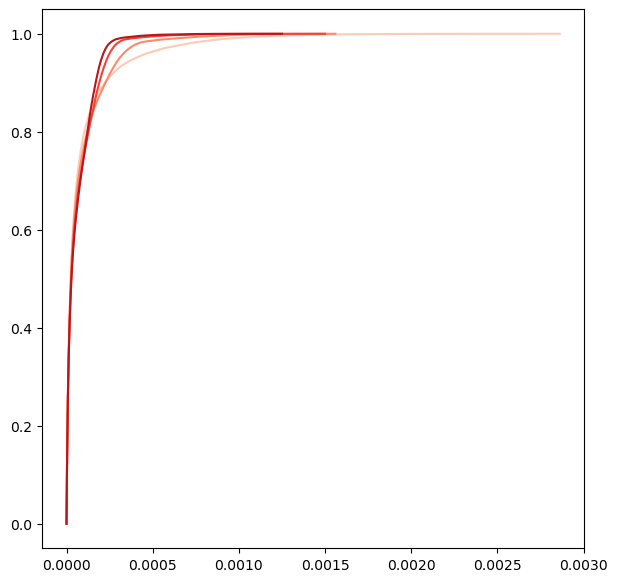

In [42]:
draw_ecdf_grad(t_g4_2)

In [101]:
t1.vertices[t1.faces[5405].p1].pnt.z

12.0

In [96]:
t1.vertices[t1.hedges[13386].origin].pnt.z

10.246

In [ ]:
make_scaleImg_series([t1, t1, t1, t1], 911644, -1277577, ground, sea, mode='dd')

In [22]:
dataFile = r"C:\Cartography\KURS\Project\Data\shpEast\Wave_len.shp" 
borderFile = r"C:\Cartography\KURS\Project\Data\shpEast\Border.shp"
coastFile = r"C:\Cartography\KURS\Project\Data\shpEast\CastN.shp"
groundFile = r"C:\Cartography\KURS\Project\Data\shpEast\GroundArea.shp"
seaFile = r"C:\Cartography\KURS\Project\Data\shpEast\SeaArea.shp"
crs = '+proj=laea +lon_0=181.5820313 +lat_0=90 +datum=WGS84 +units=m +no_defs'
coast = MultiLineString(list(gpd.read_file(coastFile).geometry))
ground = gpd.read_file(groundFile)
sea = gpd.read_file(seaFile)

t1 = Triangulation(data=dataFile, border=borderFile, crs=crs)
levels = [0, 2, 4, 6, 8]#[0, 5, 10, 15, 20, 25]
t1.calculate_levels(levels=levels)
#levels = [0, 2, 6, 8, 10, 12, 14]#[0, 5, 10, 15, 20, 25]
#t1.calculate_levels(levels=levels)

GEOMETRYCOLLECTION EMPTY
GEOMETRYCOLLECTION (LINESTRING (-1384134 -256338, -1382530 -256880, -1381746 -258248, -1381738 -258289, -1381682 -258306, -1380013 -259321, -1379643 -261115, -1379631.510431094 -261121.749112576, -1377858.2339874827 -261777.15821370328, -1375987.2229710473 -262088.09659961343, -1374095.4681615822 -262281.02804290276, -1372204.5103103563 -262474.4083037055, -1370313.351173495 -262667.54453382036, -1368423.0350965755 -262860.8800133719, -1367148 -263287, -1366756 -263215, -1366530 -263345, -1366320 -263655, -1365065 -264715, -1364894 -265539, -1364051 -266345, -1363733 -267374, -1363144 -268088, -1362445 -268707, -1361250 -269656, -1360780 -269991, -1360363 -270114, -1358702 -271074, -1358194 -271298, -1356457 -272121, -1356049 -272493, -1355020 -273650, -1354808 -274687, -1354105 -275460, -1353672 -275613, -1352306 -276474, -1351686 -276767, -1350567 -277559, -1350007 -278322, -1349297 -279015, -1349368 -279941, -1348699.3692522342 -280529.3491650971, -1349257 -

In [ ]:
fig, ax=plt.subplots(figsize=[150, 150])
ax.set_xlim(-1900000, 2100000)
ax.set_ylim(-2900000, 0)
t1.show(ax)

In [ ]:
fig, ax = plt.subplots(figsize=[10, 10])
draw_ecdf(t1.zs, ax)

In [95]:
t_b=[t1, t1, t1, t1]

In [ ]:
t_s1_1 = [t1]
for i in range(1, 4):
    ti = smoother(t_s1_1[i-1], 1)
    ti.calculate_levels(levels=levels)
    t_s1_1.append(ti)

In [63]:
t_b = [t1, t1, t1, t1]

In [ ]:
make_scaleImg_series(t_b, -1000000, -2000000, ground, sea, cmap='RdPu')

In [53]:
t_d2 = [t1]
prevs = [t1]
for i in range(1, 4):
    ti = push_value_by_dist(prevs[i-1], coast)
    ti = push_value_by_dist(ti, coast)
    ti = push_value_by_dist(ti, coast)
    ti = smoother(ti, 1)
    prevs.append(ti)
    #ti.calculate_grad()
    ti.calculate_levels(levels=levels)
    t_d2.append(ti)

GEOMETRYCOLLECTION EMPTY
GEOMETRYCOLLECTION (LINESTRING (-1148231 -181858, -1150373 -173614, -1156178.3965882596 -173453.02743373977, -1165100.1380594154 -180050.10340147954, -1165880.6588547812 -186403.6245698935, -1166752.2455286006 -193508.35883234805, -1167239.7045714727 -197475.75995280757, -1167912.1775857941 -202960.63843066728, -1168403.6571876463 -206965.7037443543, -1170281.58538836 -207308.0418377305, -1169619.4767648738 -208947.9780575158, -1168927 -210040, -1168555 -210022, -1167419 -209609, -1165036 -210549, -1164999 -210577, -1164940 -210583, -1164230 -210744, -1161556 -211128, -1161195 -211295, -1161184 -211724, -1160465 -214374, -1159656 -216238, -1159004 -217497, -1158187 -218298, -1156662 -219857, -1156148 -220325, -1155663 -220840, -1154213 -221818, -1153703 -223398, -1153720 -225834, -1153633 -227083, -1154143 -228717, -1154809 -230723, -1156037 -233021, -1157021 -234839, -1158312 -236643, -1159444 -238259, -1161420 -240676, -1162082 -241483, -1162676 -242123, -116

In [12]:
t_g1_1 = [t1]
prevs = [t1]
for i in range(1, 4):
    ti = push_value_by_grad(prevs[i-1], s=1)
    ti = smoother(ti, 1)
    prevs.append(ti)
    ti.calculate_levels(levels=levels)
    t_g1_1.append(ti)

GEOMETRYCOLLECTION EMPTY
GEOMETRYCOLLECTION (LINESTRING (-1381225 -255980, -1382325 -255021, -1382593 -254763, -1381201.3945711164 -254039.37781140764, -1379515.5067202516 -253162.80733970844, -1377828.282998246 -252285.96811917642, -1376141.904521145 -251409.2659006157, -1374455.321679522 -250532.2660829619, -1372768.4449893674 -249655.45432328194, -1371081.3164555656 -248778.59602863376, -1369393.9774751335 -247901.45778569314, -1367717.69214101 -247005.3750837047, -1366084.7689281364 -246029.7821398426, -1364477.2682008909 -245011.08945658873, -1362869.3491924761 -243992.45696557403, -1361262.1021788113 -242974.08607490492, -1359673.1563298297 -241932.9230627899, -1358541.451107679 -240484.4470895401, -1358629.7615625707 -238564.40242274816, -1358647.3544257295 -236659.84834111825, -1357714.0789603214 -235001.86331327274, -1356353.1824756355 -233666.09888047088, -1354992.5428457968 -232330.20665169257, -1353647.8254775815 -230981.54957752876, -1352759.682921137 -229285.4530813568, -

In [48]:
t_g4_2 = [t1]
prevs = [t1]
for i in range(1, 4):
    ti = push_value_by_grad(prevs[i-1], s=2)
    ti = push_value_by_grad(ti, s=2)
    ti = push_value_by_grad(ti, s=2)
    ti = smoother(ti, 1)
    prevs.append(ti)
    ti.calculate_levels(levels=levels)
    t_g4_2.append(ti)

GEOMETRYCOLLECTION EMPTY
GEOMETRYCOLLECTION (LINESTRING (-1144791 -176625, -1145681 -173745, -1156178.3965882596 -173453.02743373977, -1165100.1380594154 -180050.10340147954, -1165880.6588547812 -186403.6245698935, -1166752.2455286006 -193508.35883234805, -1167239.7045714727 -197475.75995280757, -1167751 -201648, -1166963 -202206, -1163992 -203740, -1163713 -204183, -1163220 -205839, -1162498 -207846, -1162380 -208153, -1161905 -208741, -1160496 -210666, -1159032 -212855, -1158846 -213084, -1158733 -213150, -1156042 -215536, -1155678 -215960, -1153454 -219462, -1153323 -220309, -1152636 -223308, -1152793 -224824, -1152816 -227076, -1153650 -229812, -1153925 -230593, -1155618 -233820, -1156149 -234867, -1158102 -237766, -1158676 -238562, -1161535 -241700, -1161747 -241924, -1161924 -242134, -1164925 -244533, -1165494 -244689, -1168097 -245193, -1171062 -245094, -1171286 -245176, -1171720 -245031, -1172411 -243500, -1172755 -243031, -1172761 -242978, -1172945 -241081, -1173509.8195004803

In [32]:
t_m = [t1]
for i in range(1, 4):
    ti = t_m[i-1].push_value_by_min(coast)
    ti = ti.push_value_by_min(coast)
    ti = ti.push_value_by_min(coast)
    ti.calculate_levels(levels=levels)
    t_m.append(ti)

GEOMETRYCOLLECTION EMPTY
GEOMETRYCOLLECTION (LINESTRING (-1380380 -255358, -1382852 -254897, -1382888.0867581242 -254916.31633736094, -1384128.5663485152 -256227.6997643086, -1384225.2532483712 -258058.3455877368, -1382977.1703880113 -259287.8164575666, -1381304.332357725 -260204.70045139754, -1379631.510431094 -261121.749112576, -1377858.2339874827 -261777.15821370328, -1375987.2229710473 -262088.09659961343, -1374095.4681615822 -262281.02804290276, -1372204.5103103563 -262474.4083037055, -1370313.351173495 -262667.54453382036, -1368423.0350965755 -262860.8800133719, -1368188 -262939, -1367260 -261774, -1366407 -262001, -1365601 -261376, -1365206 -260725, -1363713 -260376, -1362490 -260869, -1361333 -261218, -1359629 -261741, -1358657 -261779, -1357585 -263007, -1358832 -264179, -1359648 -264923, -1360807 -265756, -1361634 -266471, -1361304 -267369, -1361231 -268928, -1361499 -269677, -1362329 -270770, -1362905 -271477, -1363876 -272466, -1363660.5488239492 -273269.431280837, -1361903

In [34]:
t_m = [t1]
for i in range(1, 4):
    ti = t_m[i-1].push_value_by_min(coast)
    ti = ti.push_value_by_min(coast)
    ti.calculate_levels(levels=levels)
    t_m.append(ti)

GEOMETRYCOLLECTION EMPTY
GEOMETRYCOLLECTION (LINESTRING (-1382199 -256603, -1384102 -256200, -1384128.5663485152 -256227.6997643086, -1384225.2532483712 -258058.3455877368, -1382977.1703880113 -259287.8164575666, -1381304.332357725 -260204.70045139754, -1379631.510431094 -261121.749112576, -1377858.2339874827 -261777.15821370328, -1375987.2229710473 -262088.09659961343, -1374095.4681615822 -262281.02804290276, -1372204.5103103563 -262474.4083037055, -1370313.351173495 -262667.54453382036, -1368423.0350965755 -262860.8800133719, -1368188 -262939, -1367260 -261774, -1366695 -261853, -1365667 -261056, -1364589 -261988, -1363517 -262771, -1362729 -262979, -1361328 -263468, -1360415 -263749, -1359648 -264923, -1360807 -265756, -1361634 -266471, -1361304 -267369, -1361231 -268928, -1361499 -269677, -1362329 -270770, -1362905 -271477, -1363876 -272466, -1363660.5488239492 -273269.431280837, -1361903.6443320627 -273603.0278650626, -1360008.4470593317 -273761.4125662354, -1358517.5674336706 -27

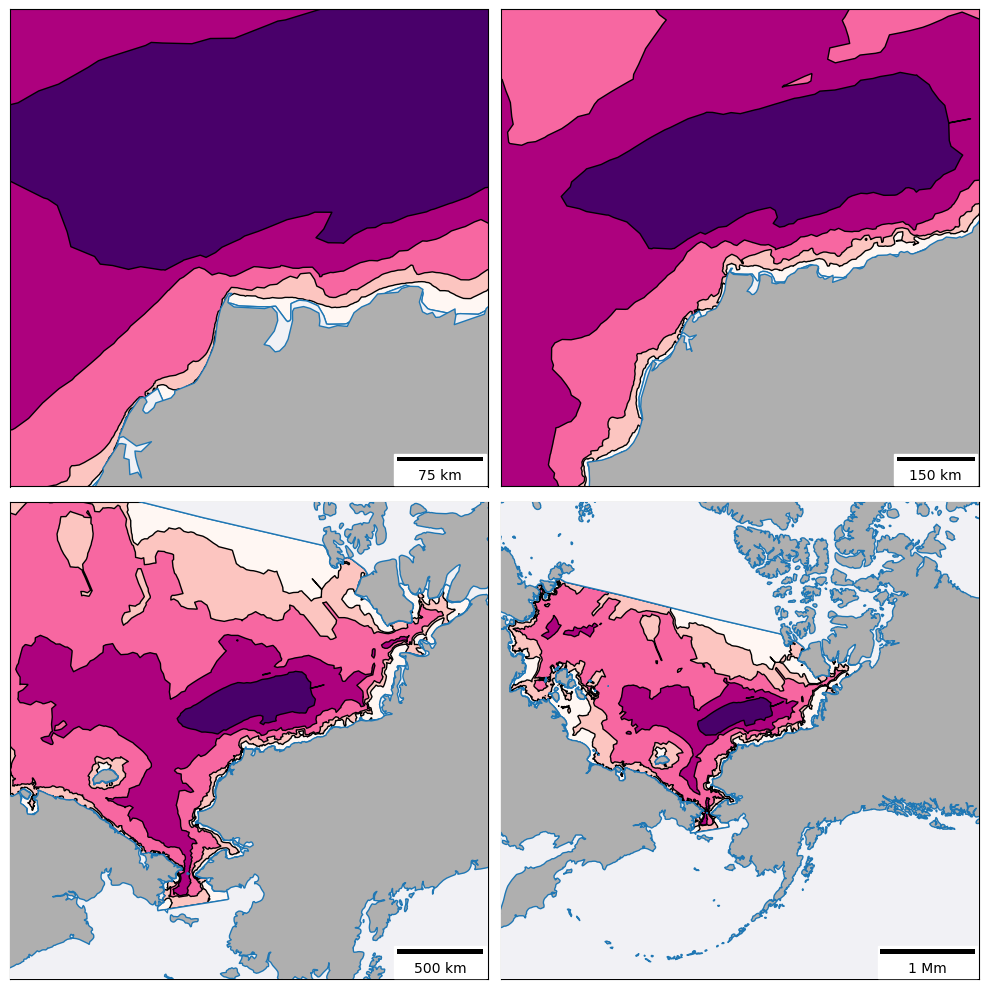

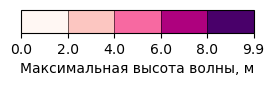

In [35]:
make_scaleImg_series(t_m, 790000, -1877577, ground, sea, cmap='RdPu', k=2.3, name="Максимальная высота волны, м")

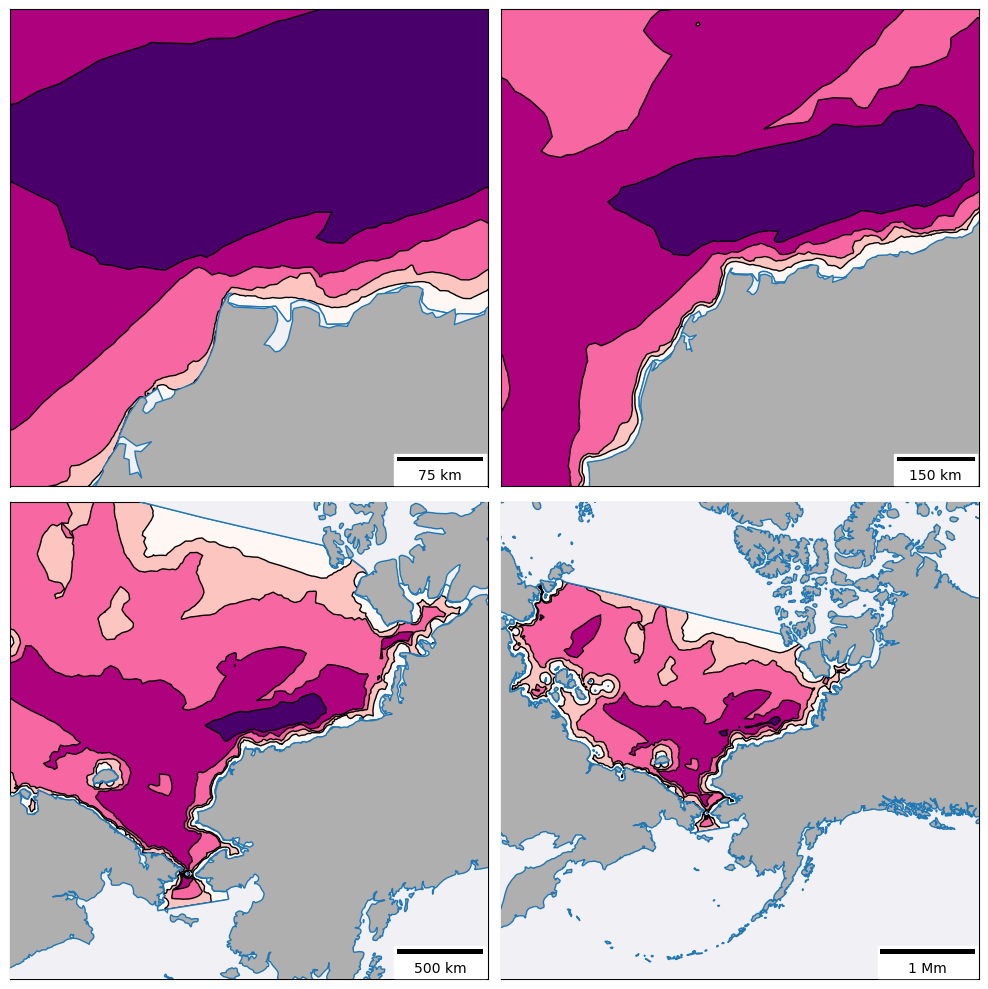

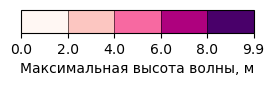

In [47]:
make_scaleImg_series(t_g4_2, 790000, -1877577, ground, sea, cmap='RdPu', k=2.3, name="Максимальная высота волны, м")

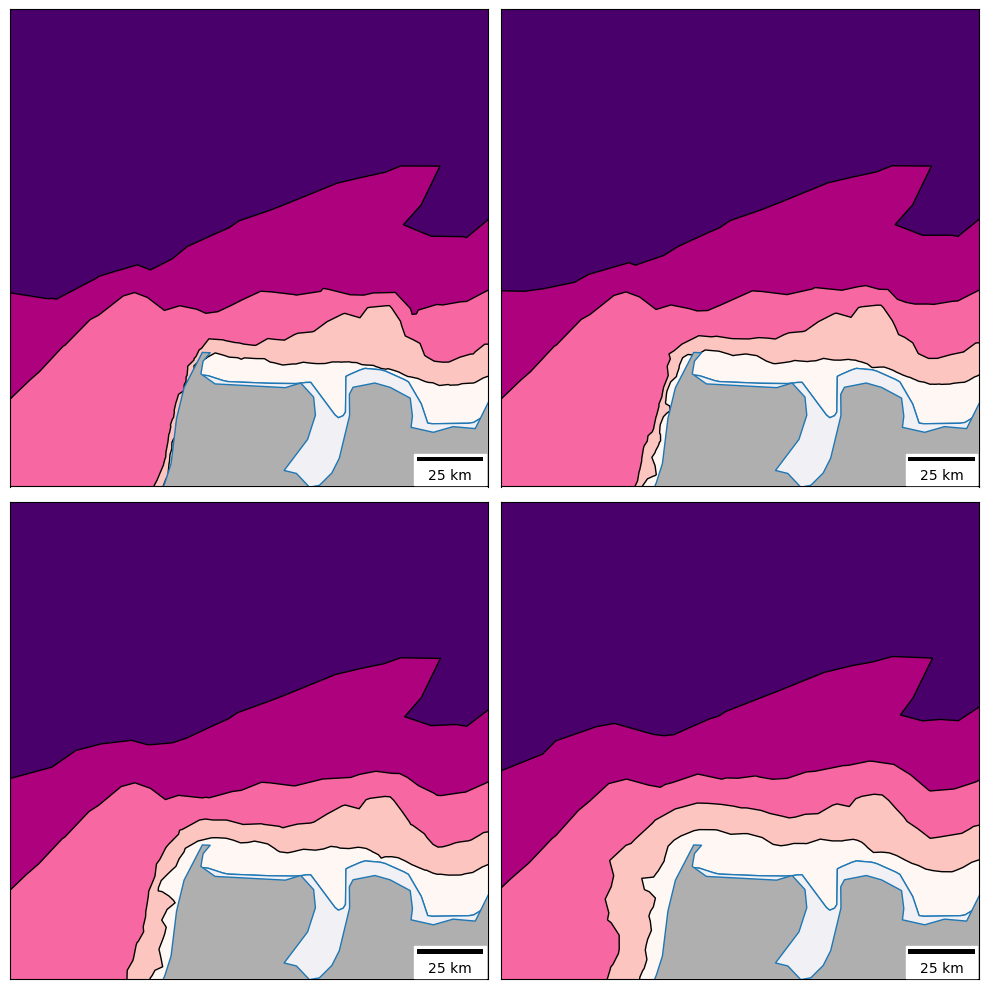

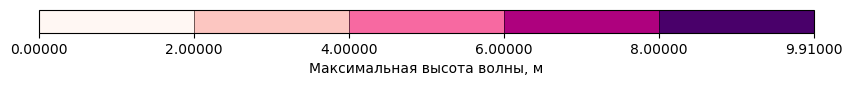

In [43]:
make_closeImg_series(t_g4_2, 790000, -1877577, ground, sea, cmap='RdPu', name="Максимальная высота волны, м")

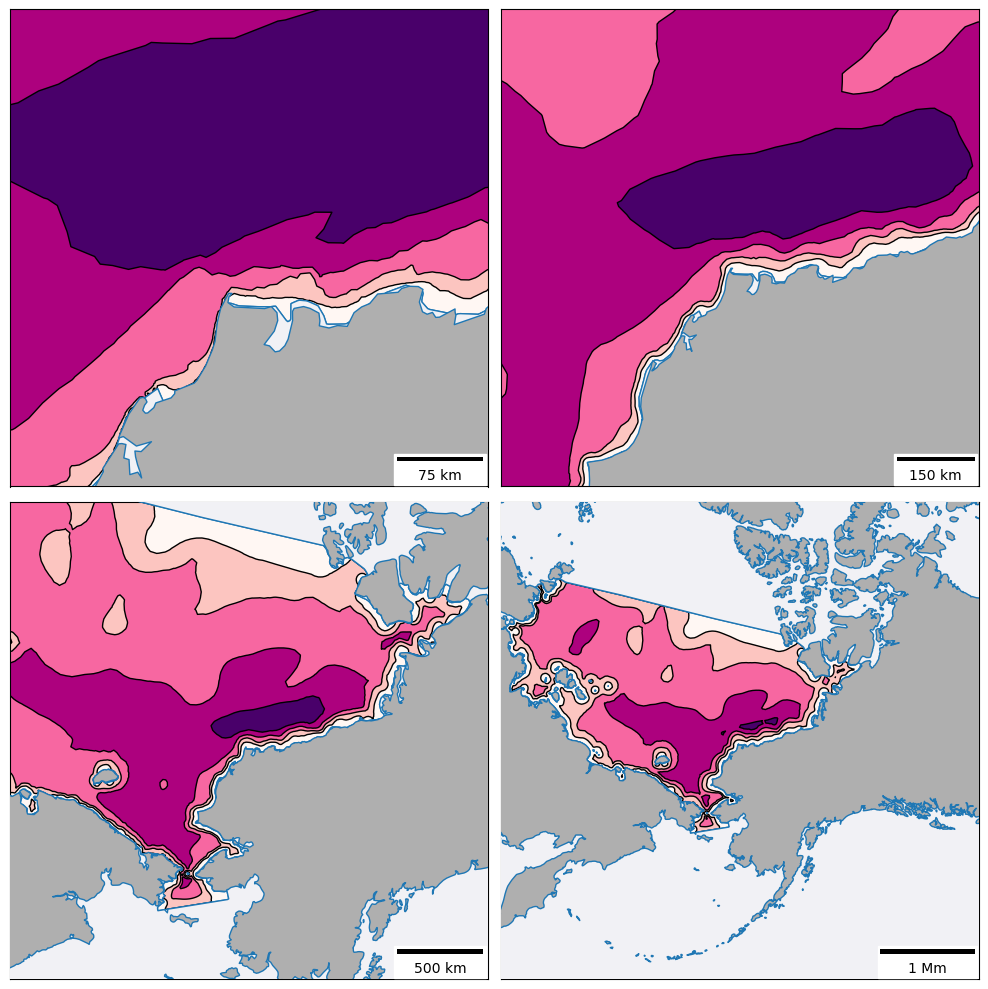

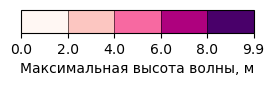

In [49]:
make_scaleImg_series(t_g4_2, 790000, -1877577, ground, sea, cmap='RdPu', k=2.3, name="Максимальная высота волны, м")

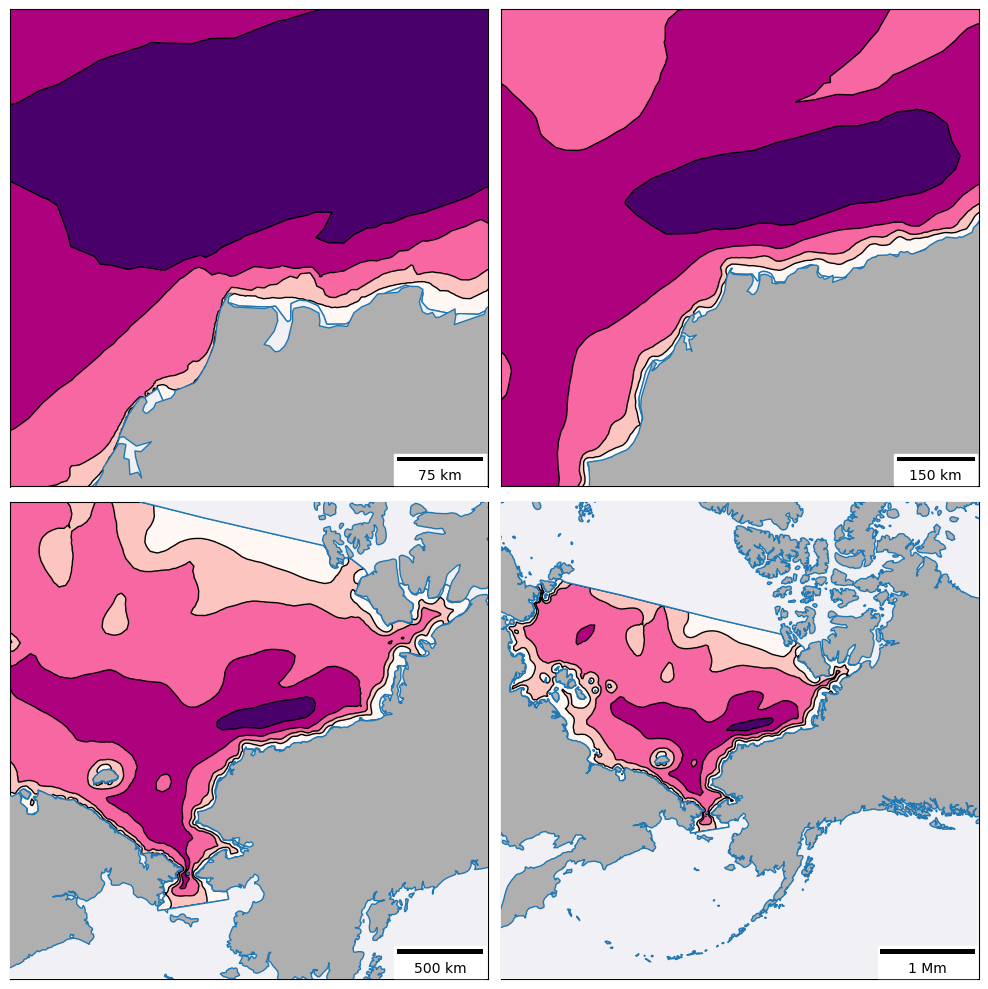

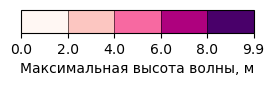

In [54]:
make_scaleImg_series(t_d2, 790000, -1877577, ground, sea, cmap='RdPu', k=2.3, name="Максимальная высота волны, м")

In [ ]:
make_closeImg_series(t_g2, -1000000, -2000000, ground, sea, 1000000)

In [ ]:
make_closeImg_series(t_s2_3, -1000000, -2000000, ground, sea, 1000000)

In [ ]:
make_closeImg_series(t_g2, -1000000, -2000000, ground, sea, 150000)

In [ ]:
make_closeImg_series(t_d2, -1000000, -2000000, ground, sea, 150000)

In [93]:
t_d[1].calculate_grad()
t_d[2].calculate_grad()
t_d[3].calculate_grad()
t_g[3].calculate_grad()

In [ ]:
t_g[0].edges[1000].grad

In [ ]:
draw_ecdf_zs(t_g)
draw_ecdf_grad(t_g)

In [67]:
r = "C:\Cartography\KURS\Project\Data\shp Каспий\Esr_Kaspiy.csv"
c = "C:\Cartography\KURS\Project\Data\shp Каспий\KaspPol.shp"
g = r"C:\Cartography\KURS\Project\Data\shp Каспий\ground.shp"

gdfp = gpd.read_file(r)
gdfl = gpd.read_file(c)
groundK = gpd.read_file(g)

In [68]:
t2 = Triangulation(gdfp, gdfl)
t2.change_projection("EPSG:3857")
levels2 = [0, 1, 2, 3, 4]
t2.calculate_levels(levels=levels2)


GEOMETRYCOLLECTION EMPTY
GEOMETRYCOLLECTION (LINESTRING (5754881 4388569, 5754837 4388578, 5752360 4388629, 5752217 4388659, 5752145 4388657, 5749897 4389479, 5749807 4389505, 5746953 4390254, 5746836 4390278, 5746725 4390364, 5744149 4391701, 5743844 4391857, 5741727 4392761, 5741465 4392888, 5739250 4394234, 5738929 4394346, 5738617 4394544, 5736319 4395860, 5735557 4395863, 5733838 4396545, 5732592 4395486, 5731958 4395700, 5731863 4395743, 5729966 4396193, 5729915 4396216, 5728006 4397216, 5727899 4397250, 5727793 4397278, 5725615 4397894, 5725477 4397917, 5723444 4398644, 5723283 4398671, 5721047 4398454, 5720915 4398483, 5720796 4398503, 5718725 4398648, 5718621 4398656, 5716853 4399024, 5716730 4399034, 5714450 4399180, 5714341 4399189, 5714232 4399189, 5712043 4399477, 5711955 4399484, 5711664 4399569, 5710179 4401416, 5709516 4401516, 5707609 4401818, 5706923 4402003, 5704969 4402032, 5704353 4402132, 5702545 4402595, 5701941 4402644, 5701264 4402789, 5699331 4403378, 5698626 

In [69]:
t_k = [t2]
prevs = [t2]
for i in range(1, 4):
    ti = push_value_by_grad(prevs[i-1], s=2)
    ti = push_value_by_grad(ti, s=2)
    ti = smoother(ti, 1)
    prevs.append(ti)
    ti.calculate_levels(levels=levels2)
    t_k.append(ti)

GEOMETRYCOLLECTION EMPTY
GEOMETRYCOLLECTION (LINESTRING (5782950 4393524, 5781621 4392957, 5780012 4392836, 5777099 4392980, 5775317 4393586, 5771899 4393626, 5771059 4393628, 5770269 4393860, 5766729 4395240, 5765963 4395662, 5761129 4396284, 5760970 4396316, 5760810 4396315, 5756043 4395897, 5755857 4395943, 5752009 4397045, 5751423 4397064, 5747105 4398186, 5746778 4398338, 5746480 4398486, 5742565 4398842, 5741714 4399063, 5739442 4400348, 5738122 4401069, 5736881 4403025, 5735036 4403890, 5733511 4404487, 5731294 4404557, 5728421 4405285, 5727759 4405465, 5727410 4404854, 5724172 4404220, 5721979 4404527, 5720597 4405037, 5718254 4405783, 5716201 4406576, 5713701 4406736, 5712015 4407236, 5709996 4408043, 5707653 4409668, 5706468 4410603, 5705109 4410570, 5701817 4411471, 5700010 4411997, 5696897 4413582, 5695601 4413867, 5694139 4414073, 5691384 4414416, 5689317 4414036, 5687512 4413406, 5685643 4413770, 5683148 4414171, 5682375 4414527, 5681657 4414828, 5678808 4415941, 5677547 

In [ ]:
n = 100
print(t1.vertices[n].grad)
fig, ax = plt.subplots(figsize=[15, 15])
gpd.GeoSeries.plot(gpd.GeoSeries(t1.ml), ax=ax)
gpd.GeoSeries.plot(gpd.GeoSeries(t1.vertices[n].pnt), ax=ax, color='r')


In [19]:
t2 = push_value_by_grad(t1)
t2 = t2.smoother()


In [73]:
t3 = t2.push_value_by_min()
t3 = t3.smoother()
t3.calculate_grad()

In [76]:
print(calculate_stat(t1), calculate_stat(t2), calculate_stat(t3))

16.10168590084519 14.598147822725554 14.327311569669746


In [70]:
t_b = [t2, t2, t2, t2]

In [72]:
Kt_g2 = [t2]
prevs = [t2]
for i in range(1, 4):
    ti = push_value_by_grad(prevs[i-1])
    ti = push_value_by_grad(ti)
    ti = push_value_by_grad(ti)
    ti = smart_smoother(ti, 3)
    prevs.append(ti)
    
    #ti.calculate_grad()
    ti.calculate_levels(levels=levels2)
    Kt_g2.append(ti)

GEOMETRYCOLLECTION EMPTY
GEOMETRYCOLLECTION (LINESTRING (5450149.197131113 4560641.353004754, 5450162.62411569 4560442.546238865, 5450758.866692641 4558680.405352694, 5451315.464146607 4556706.812183929, 5451872.061600573 4554733.593569177, 5452317.339563746 4552760.749248531, 5452873.937017713 4550647.402533224, 5453319.214980885 4548675.332710113, 5453987.131925645 4546703.636384025, 5454766.368361197 4544873.109715583, 5455545.604796751 4542902.1329735825, 5456324.841232304 4541072.27404337, 5456992.758177063 4539242.73629817, 5457771.9946126165 4537272.823838038, 5458773.870029756 4535584.623535411, 5459998.3844284825 4534177.998608417, 5461334.218318001 4532771.563270745, 5462558.732716727 4531505.933488075, 5463783.247115454 4530099.858111376, 5465119.081004973 4528693.972051735, 5466343.595403698 4527288.275215365, 5467679.429293218 4526023.309771054, 5468903.943691944 4524617.972200692, 5470239.777581464 4523353.329943622, 5471686.930961776 4522229.331924801, 5473134.084342089 

In [ ]:
fig, ax = plt.subplots(figsize = [40, 20])
gpd.GeoSeries.plot(gpd.GeoSeries([i.lin for i in t2.edges]), ax=ax)
        

In [ ]:
t_s4 = [t1]
for i in range(1, 4):
    ti = smart_smoother(t_s4[i-1], 1)
    ti = smart_smoother(ti, 1)
    ti = smart_smoother(ti, 1)
    t_s4.append(smart_smoother(ti, 1))
    t_s4[i].calculate_levels(levels=levels)

In [ ]:
t_s3 = [t1]
for i in range(1, 4):
    ti = smart_smoother(t_s3[i-1], 1)
    ti = smart_smoother(ti, 1)
    t_s3.append(smart_smoother(ti, 1))
    t_s3[i].calculate_levels(levels=levels)

In [ ]:
t_s1_2 = [t1]
for i in range(1, 4):
    t_s1_2.append(smart_smoother(t_s1_2[i-1], 2))
    t_s1_2[i].calculate_levels(levels=levels)

In [ ]:
t_s1_3 = [t1]
for i in range(1, 4):
    t_s1_3.append(smart_smoother(t_s1_3[i-1], 3))
    t_s1_3[i].calculate_levels(levels=levels)

In [ ]:
t_s2_3 = [t1]
for i in range(1, 4):
    ti = smart_smoother(t_s2_3[i-1], 3)
    t_s2_3.append(smart_smoother(ti, 3))
    t_s2_3[i].calculate_levels(levels=levels)

In [ ]:
t_s3_3 = [t1]
for i in range(1, 4):
    ti = smart_smoother(t_s3_3[i-1], 3)
    ti = smart_smoother(ti, 3)
    t_s3_3.append(smart_smoother(ti, 3))
    t_s3_3[i].calculate_levels(levels=levels)

In [ ]:
t_s2 = [t1]
for i in range(1, 4):
    ti = smart_smoother(t_s2[i-1], 1)
    t_s2.append(smart_smoother(ti, 1))
    t_s2[i].calculate_levels(levels=levels)

In [ ]:
t_g = [t1]
for i in range(1, 4):
    ti = push_value_by_grad(t_g[i-1])
    ti = smart_smoother(ti, 3)
    #ti.calculate_grad()
    ti.calculate_levels(levels=levels)
    t_g.append(ti)

In [ ]:
t_d = [t1]
for i in range(1, 4):
    ti = push_value_by_dist(t_d[i-1], coast)
    ti = smart_smoother(ti, 3)
    #ti.calculate_grad()
    ti.calculate_levels(levels=levels)
    t_d.append(ti)

In [ ]:
t_g2 = [t1]
for i in range(1, 4):
    ti = push_value_by_grad(t_g2[i-1])
    ti = push_value_by_grad(ti)
    ti = smart_smoother(ti, 3)
    #ti.calculate_grad()
    ti.calculate_levels(levels=levels)
    t_g2.append(ti)

In [ ]:
t_d2 = [t1]
for i in range(1, 4):
    ti = push_value_by_dist(t_d2[i-1], coast)
    ti = push_value_by_dist(ti, coast)
    ti = smart_smoother(ti, 3)
    #ti.calculate_grad()
    ti.calculate_levels(levels=levels)
    t_d2.append(ti)

In [61]:
void = gpd.GeoSeries([Polygon(((0, 0), (1, 1), (1, 0), (0, 0)))]) #5550000, 4920000

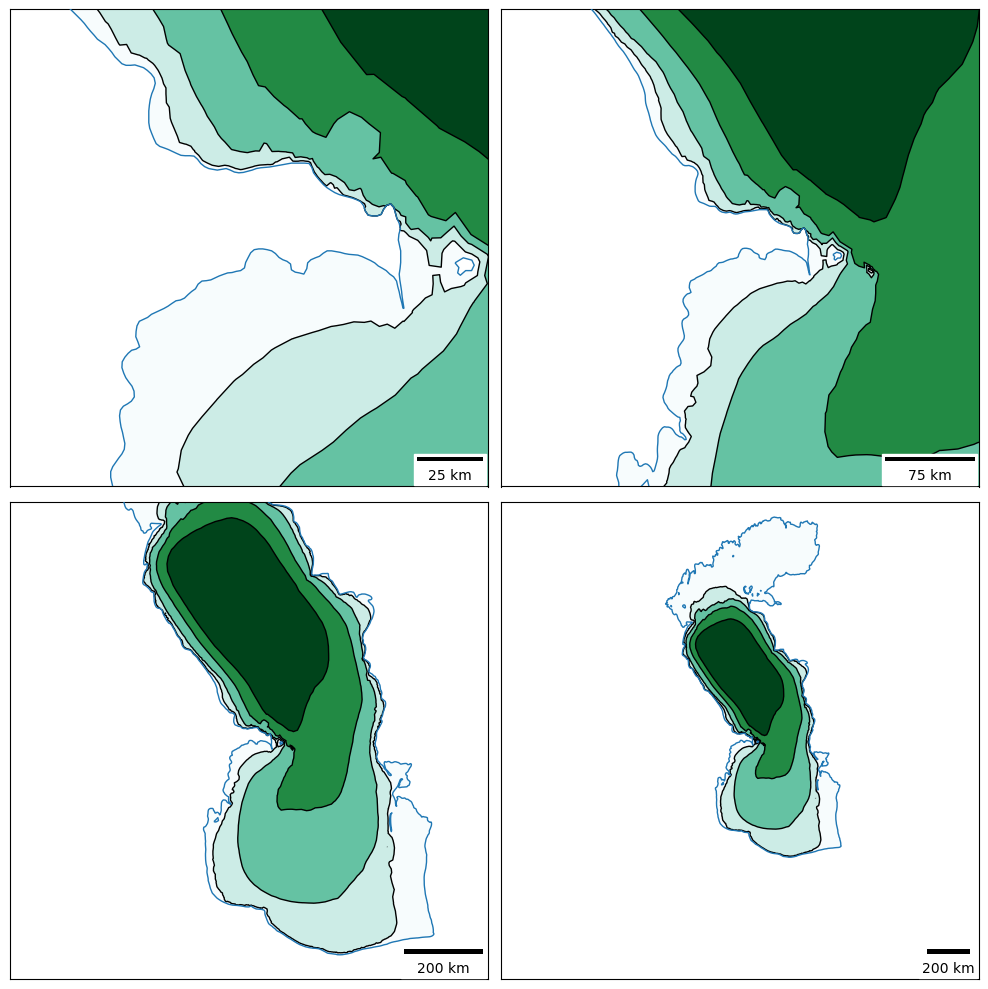

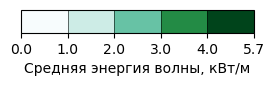

In [70]:
make_scaleImg_series([t2, t2, t2, t2], 5550000, 4920000, ground=void, sea=void, name='Средняя энергия волны, кВт/м')

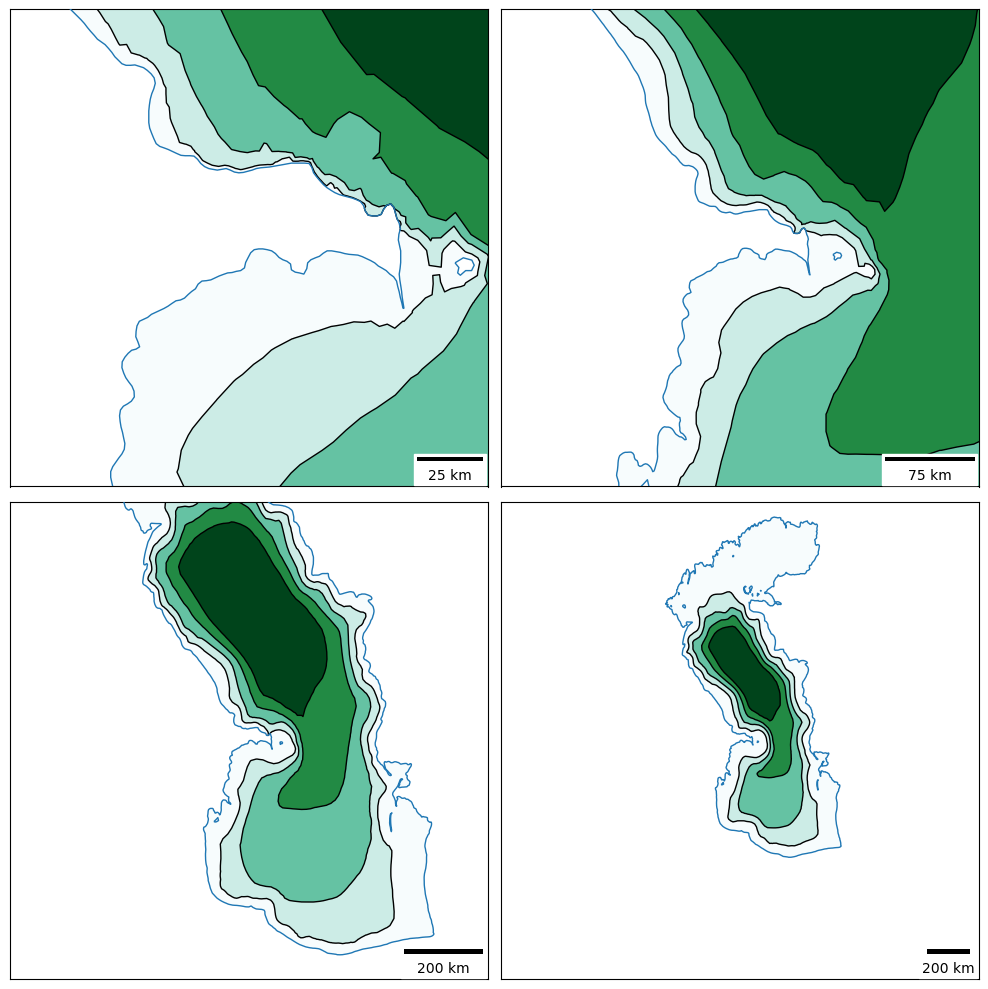

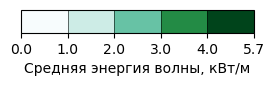

In [71]:
make_scaleImg_series(t_k, 5550000, 4920000, ground=void, sea=void, name='Средняя энергия волны, кВт/м')

In [60]:
make_closeImg_series(t_k, 5550000, 4920000, ground=void, sea=void, cmap='RdPu')

NameError: name 'void' is not defined

In [ ]:
Kt_s1 = [t2]
for i in range(1, 4):
    Kt_s1.append(smart_smoother(Kt_s1[i-1], 1))
    Kt_s1[i].calculate_levels(levels=levels2)

In [ ]:
make_scaleImg_series(Kt_g2, 5550000, 4920000, void, void, cmap='RdPu')

In [ ]:
make_scaleImg_series(t_d2, 5550000, 4920000)

In [ ]:
make_closeImg_series(t_2g, 5550000, 4920000)

In [ ]:
make_closeImg_series(t_d2, 5550000, 4920000)

In [34]:
t1.save_to_shp(r"C:\Cartography\KURS\Project\Data\shp Каспий\SHP_KASP.shp")

In [ ]:
c1 = r"C:\Cartography\KURS\Project\Data\DIST_TEST.csv"
s2 = r"C:\Cartography\KURS\Project\Data\shp Каспий\SHP_TEST.shp"
levels = [0.4, 0.6, 0.8]

t2.show_levels(levels=levels)

In [ ]:
fig, ax = plt.subplots(figsize=[15, 15])
  
ax.set_xlim(t2.vertices[3950].pnt.x - 5000, t2.vertices[3950].pnt.x + 5000)
ax.set_ylim(t2.vertices[3950].pnt.y - 5000, t2.vertices[3950].pnt.y + 5000)
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
t2.calculate_edges()
gpd.GeoSeries.plot(gpd.GeoSeries([v.lin for v in t2.edges]), ax=ax)
gpd.GeoSeries.plot(gpd.GeoSeries([v.pnt for v in t2.vertices]), ax=ax)
gpd.GeoSeries.plot(gpd.GeoSeries(t2.ml), ax=ax, color='red')

plt.show()  